<a href="https://colab.research.google.com/github/chitra-psg/Course/blob/master/telecom_churn_prediction_gc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn Prediction

**Author:** Chitra Govindasamy

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import os
from datetime import datetime as dt

#sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler ,OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score ,confusion_matrix, precision_score, recall_score ,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV ,RepeatedStratifiedKFold ,cross_val_score ,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Common Functions

In [2]:
## Common Function to plot the countplot
def PlotAttribute(df_data, attribute, title, xlabel, ylabel, hueattribute = None, order = None):  
  if ( hueattribute ):
    chrt = sns.countplot(x=attribute,hue=hueattribute, data=df_data, order=order)
  else:
    chrt = sns.countplot(x=attribute,data=df_data)
  chrt.set_title(title,fontsize=14)
  chrt.set_xlabel(xlabel,fontsize=14)
  chrt.set_ylabel(ylabel,fontsize=14) 

  # To show count of values above bars
  for patch in chrt.patches:
      x, y = patch.get_xy()   # Bottom-left corner. 
      x += patch.get_width()/2 # Middle of the width.
      y += patch.get_height()  # Top of the bar
      color = patch.get_facecolor()
      chrt.text(x, y, str(y))
  return chrt

In [3]:
#2 decimal places
pd.options.display.float_format = '{:.2f}'.format
# The dataset has many columns and the list is getting truncated in the output. Hence, adjusting the configuration
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('mode.use_inf_as_na', True)
#chart style
sns.set_style('darkgrid')

In [4]:
def plot(hyperparameters,scores):
     # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters].data, scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters].data, scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [5]:
# Uses Random Forest pipeline , purpose to hyper parameter tuning of the model
def rf_model(params,pipe,X_train,y_train):
    folds = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    model = GridSearchCV(estimator=pipe, cv=folds, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=1,return_train_score=True)
    model.fit(X_train,y_train)
    return model.cv_results_


In [6]:
## Common Function to plot the countplot
def PlotAttribute(df_data, attribute, title, xlabel, ylabel, hueattribute = None, order = None):  
  if ( hueattribute ):
    chrt = sns.countplot(x=attribute,hue=hueattribute, data=df_data, order=order)
  else:
    chrt = sns.countplot(x=attribute,data=df_data)
  chrt.set_title(title,fontsize=14)
  chrt.set_xlabel(xlabel,fontsize=14)
  chrt.set_ylabel(ylabel,fontsize=14) 

  # To show count of values above bars
  for patch in chrt.patches:
      x, y = patch.get_xy()   # Bottom-left corner. 
      x += patch.get_width()/2 # Middle of the width.
      y += patch.get_height()  # Top of the bar
      color = patch.get_facecolor()
      chrt.text(x, y, str(y))
  return chrt

In [7]:
# Handle outlier using k-sigmoid method (Reference : starter notebook)
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [8]:
# Common Function to process data
def Preprocess(df_data, action):  
  if ( action == 'DropUniqueColumns' ):
    df_data.drop(['id'], axis=1, inplace=True)
  elif(action == 'Drop0VariationColumns'):
    df_data.drop(['circle_id',
                  'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
                  'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
                  'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'], axis=1, inplace=True)
    #               'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
  elif(action == 'DeriveLastRechargeDay'):
    CURRENT_DAY = (dt.strptime('2014/9/01', "%Y/%m/%d")) #assuming we are in the begining of Sep trying to predict churn so that necessary actions can be taken to prevent churn
    df_data['lastrechargedayago'] = abs(((df_data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1) ) - CURRENT_DAY).dt.days)
    df_data.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis = 1, inplace = True)
    df_data['lastdatarechargedayago'] = abs(((df_data[['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']].max(axis=1) ) - CURRENT_DAY).dt.days)
    df_data.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis = 1, inplace = True)
  elif(action == 'Fill0inFloatColumns'):
    for col in data.select_dtypes(include="float64").columns:
        df_data[col].fillna(0, inplace=True)
  elif(action == 'ConverttoDate'):
      # Convert date columns to date format
      for col in data.select_dtypes(include="object").columns:
          df_data[col] =  pd.to_datetime(df_data[col], format='%m/%d/%Y')
  elif(action == 'HandleOutlier'):
      df_data = df_data.apply(cap_outliers, axis=0)
  elif(action == 'DeriveAdditionalFeatures'):  
    df_data['vol_mb_6'] =  df_data['vol_2g_mb_6']  + df_data['vol_3g_mb_6'] 
    df_data['vol_mb_7'] =  df_data['vol_2g_mb_7']  + df_data['vol_3g_mb_7']  
    df_data['vol_mb_8'] =  df_data['vol_2g_mb_8']  + df_data['vol_3g_mb_8']  
    df_data['vol_mb_67'] =  (df_data[['vol_mb_6', 'vol_mb_7']].max(axis=1) )
    df_data['datavolusagegrowth'] =  -1.0
    # round( (df_data['vol_mb_8']  /  df_data['vol_mb_8']  ), 1)
    df_data['datavolusagegrowth'].loc[df_data['vol_mb_67'] == 0]  =  round( (df_data['vol_mb_8']  /  df_data['vol_mb_8']  ), 1)
    df_data['datavolusagegrowth'].loc[df_data['vol_mb_67'] != 0]  = round( (df_data['vol_mb_8']  /  df_data['vol_mb_67']  ), 1)
    df_data['datavolusagegrowth'].fillna(0, inplace=True)
    df_data.drop(['vol_2g_mb_6', 'vol_3g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_8', 'vol_mb_6', 'vol_mb_7','vol_mb_8','vol_mb_67'], axis = 1, inplace = True)
  elif(action == 'DropRedundantColumns'):  
    # loc_og_mou_* = loc_og_t2t_mou_*  + loc_og_t2m_mou_*   + loc_og_t2f_mou_* 	     + loc_og_t2c_mou_*
    df_data.drop(['loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6',
                  'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7',
                  'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8'], axis = 1, inplace = True)
     # std_og_mou_* = std_og_t2t_mou_*  + std_og_t2m_mou_*   + std_og_t2f_mou_* 	     + std_og_t2c_mou_*
    df_data.drop(['std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_t2c_mou_6',
                  'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_t2c_mou_7',
                  'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8'], axis = 1, inplace = True)
    # loc_ic_mou_* = loc_ic_t2t_mou_*  + loc_ic_t2m_mou_*   + loc_ic_t2f_mou_* 	     + loc_ic_t2c_mou_*
    df_data.drop(['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6',
                  'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7',
                  'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8'], axis = 1, inplace = True)
     # std_ic_mou_* = std_ic_t2t_mou_*  + std_ic_t2m_mou_*   + std_ic_t2f_mou_* 	     + std_ic_t2c_mou_*
    df_data.drop(['std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6',
                  'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7',
                  'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8'], axis = 1, inplace = True)
    # total_og_mou_* = loc_og_mou_* + std_og_mou_* + isd_og_mou_* + spl_og_mou_* + <x> component
    #df_data.drop(['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8',
    #              'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
    #              'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
    #              'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8'], axis = 1, inplace = True)
    # total_ic_mou_* = loc_ic_mou_* + std_ic_mou_* + spl_ic_mou_* + isd_ic_mou_* + <y> component
    #df_data.drop(['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8',
    #              'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8',
    #              'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8',
    #              'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8'], axis = 1, inplace = True)
  return df_data

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [9]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
#sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
#print(sample.shape)
print(data_dict.shape)

(11652, 172)
(11649, 171)
(36, 2)


# 2. Data Preparation

In [10]:
data.head().T

,0,1,2,3,4
id,0,1,2,3,4
circle_id,109,109,109,109,109
loc_og_t2o_mou,0.00,0.00,0.00,0.00,0.00
std_og_t2o_mou,0.00,0.00,0.00,0.00,0.00
loc_ic_t2o_mou,0.00,0.00,0.00,0.00,0.00
last_date_of_month_6,6/30/2014,6/30/2014,6/30/2014,6/30/2014,6/30/2014
last_date_of_month_7,7/31/2014,7/31/2014,7/31/2014,7/31/2014,7/31/2014
last_date_of_month_8,8/31/2014,8/31/2014,8/31/2014,8/31/2014,8/31/2014
arpu_6,31.28,0.00,60.81,156.36,240.71
arpu_7,87.01,122.79,103.18,205.26,128.19


Let's look at each variable's datatype:

In [11]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11652 entries, 0 to 11651
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

Note: Most of the fields are numeric and few date fields are object type which needs to be converted to date

In [12]:
data.describe(include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,11652.00,11652.00,11529.00,11529.00,11529.00,11652,11580,11518,11652.00,11652.00,11652.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11652.00,11652.00,11652.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11181.00,11192.00,11001.00,11180.00,11191.00,11000.00,11651.00,11651.00,11651.00,11180.00,11191.00,11000.00,11180.00,11191.00,11000.00,11180.00,11191.00,11000.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11469,11435,11215,11651.00,11651.00,11651.00,2882,2995,3021,2882.00,2995.00,3021.00,2882.00,2995.00,3021.00,2882.00,2995.00,3021.00,2882.00,2995.00,3021.00,2882.00,2995.00,3021.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,2882.00,2995.00,3021.00,2882.00,2995.00,3021.00,2882.00,2995.00,3021.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,11651.00,2882.00,2995.00,302

Note: 
1. There are fields like ID, circle ID which may not requried for further analysis. as ID is unique row ID and circle ID has zero variation. 
2. There are outliers in the data
3. There are few fields like night_pack, fb_user which have 0 or 1 (and null) which implies is a categorical field.

In [13]:
# Get the unique count
for col in data.columns:
    print("No of rows in " + col + ": ", len(data[col].unique()))

No of rows in id:  11652
No of rows in circle_id:  1
No of rows in loc_og_t2o_mou:  2
No of rows in std_og_t2o_mou:  2
No of rows in loc_ic_t2o_mou:  2
No of rows in last_date_of_month_6:  1
No of rows in last_date_of_month_7:  2
No of rows in last_date_of_month_8:  2
No of rows in arpu_6:  10913
No of rows in arpu_7:  10890
No of rows in arpu_8:  10680
No of rows in onnet_mou_6:  6558
No of rows in onnet_mou_7:  6472
No of rows in onnet_mou_8:  6341
No of rows in offnet_mou_6:  8458
No of rows in offnet_mou_7:  8427
No of rows in offnet_mou_8:  8228
No of rows in roam_ic_mou_6:  1605
No of rows in roam_ic_mou_7:  1276
No of rows in roam_ic_mou_8:  1196
No of rows in roam_og_mou_6:  1843
No of rows in roam_og_mou_7:  1429
No of rows in roam_og_mou_8:  1377
No of rows in loc_og_t2t_mou_6:  4496
No of rows in loc_og_t2t_mou_7:  4471
No of rows in loc_og_t2t_mou_8:  4428
No of rows in loc_og_t2m_mou_6:  6644
No of rows in loc_og_t2m_mou_7:  6590
No of rows in loc_og_t2m_mou_8:  6521
No of

We can observe from the above result that, the following fields have few values which may not be useful for analysis

id 

=> ***Unique value ***

circle_id ; last_date_of_month_6; last_date_of_month_7; last_date_of_month_8 

=> ***same values across all rows***; 

loc_og_t2o_mou; std_og_t2o_mou; loc_ic_t2o_mou
std_og_t2c_mou_6; std_og_t2c_mou_7; std_og_t2c_mou_8
std_ic_t2o_mou_6; std_ic_t2o_mou_7; std_ic_t2o_mou_8 

=>*** Only 0 or NULL value in these columns***


In [14]:
distinct_value = data.nunique()
distinct_value

id                          11652
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      10913
arpu_7                      10890
arpu_8                      10680
onnet_mou_6                  6557
onnet_mou_7                  6471
onnet_mou_8                  6340
offnet_mou_6                 8457
offnet_mou_7                 8426
offnet_mou_8                 8227
roam_ic_mou_6                1604
roam_ic_mou_7                1275
roam_ic_mou_8                1195
roam_og_mou_6                1842
roam_og_mou_7                1428
roam_og_mou_8                1376
loc_og_t2t_mou_6             4495
loc_og_t2t_mou_7             4470
loc_og_t2t_mou_8             4427
loc_og_t2m_mou_6             6643
loc_og_t2m_mou_7             6589
loc_og_t2m_mou_8             6520
loc_og_t2f_mou

Check % of NULLs in each column

In [15]:
(data.isnull().sum()/ len(data)) * 100

id                          0.00
circle_id                   0.00
loc_og_t2o_mou              1.06
std_og_t2o_mou              1.06
loc_ic_t2o_mou              1.06
last_date_of_month_6        0.00
last_date_of_month_7        0.62
last_date_of_month_8        1.15
arpu_6                      0.00
arpu_7                      0.00
arpu_8                      0.00
onnet_mou_6                 4.04
onnet_mou_7                 3.95
onnet_mou_8                 5.59
offnet_mou_6                4.04
offnet_mou_7                3.95
offnet_mou_8                5.59
roam_ic_mou_6               4.04
roam_ic_mou_7               3.95
roam_ic_mou_8               5.59
roam_og_mou_6               4.04
roam_og_mou_7               3.95
roam_og_mou_8               5.59
loc_og_t2t_mou_6            4.04
loc_og_t2t_mou_7            3.95
loc_og_t2t_mou_8            5.59
loc_og_t2m_mou_6            4.04
loc_og_t2m_mou_7            3.95
loc_og_t2m_mou_8            5.59
loc_og_t2f_mou_6            4.04
loc_og_t2f

Few columns have more than 70% missing values. The missing values % for month 6,7,8 across various fields here and it looks like the customers didnt recharge that particualr month and hence the metrics related to that month is also null. 

The list columns can be grouped as arpu, mou, ic, og, rech, 3g mb, 2g mb, service flag fields like - night pack, monthly 2g,3g, sachet, fb service. In places where there is null it means the facility was not used e.g. mou null indicate no call was made so these can be filled with 0. Flag fields like fb service being null indicate that the service wasnt used and that be 0 as well.

As per the problem statement is focussed on high value customers churn probability. A customer whose recharge amount is at higher end ( e.g. more than average recharge amount) will be considered high value customers. So, lets keep the rech related columns for now and impute missing values. 

In [16]:
outlier = data.describe().T.round(2)
outlier['flag'] =  (outlier['75%'] != 0) | (((outlier['max'] - outlier['75%']) / (outlier['75%'] - outlier['50%'])) > 50)
outlier

,count,mean,std,min,25%,50%,75%,max,flag
id,11652.00,5825.50,3363.79,0.00,2912.75,5825.50,8738.25,11651.00,True
circle_id,11652.00,109.00,0.00,109.00,109.00,109.00,109.00,109.00,True
loc_og_t2o_mou,11529.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
std_og_t2o_mou,11529.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
loc_ic_t2o_mou,11529.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
arpu_6,11652.00,278.65,303.97,-2041.23,94.93,198.41,365.72,11505.51,True
arpu_7,11652.00,272.11,285.33,-1289.71,85.95,191.22,364.58,4155.77,True
arpu_8,11652.00,274.09,293.81,-945.81,84.12,193.58,366.28,5748.25,True
onnet_mou_6,11181.00,129.35,283.78,0.00,7.14,33.94,116.14,4549.89,True
onnet_mou_7,11192.00,130.49,296.69,0.00,6.73,32.33,114.12,5833.71,True


###Note : Most of the attributes have outlier in it. We could treat the outliers by removing the records are handle them via. scaling technique (Robust Scaler)

#3. Preprocessing

In [17]:
data = Preprocess(data,'DropUniqueColumns')
data = Preprocess(data,'Drop0VariationColumns')
data = Preprocess(data,'ConverttoDate')
data = Preprocess(data,'DeriveLastRechargeDay')
data = Preprocess(data,'Fill0inFloatColumns')
data = Preprocess(data,'DeriveAdditionalFeatures')
data = Preprocess(data,'DropRedundantColumns')
data = Preprocess(data,'HandleOutliers')


In [18]:
(data.isnull().sum()/ len(data)) * 100

arpu_6                   0.00
arpu_7                   0.00
arpu_8                   0.00
onnet_mou_6              0.00
onnet_mou_7              0.00
onnet_mou_8              0.00
offnet_mou_6             0.00
offnet_mou_7             0.00
offnet_mou_8             0.00
roam_ic_mou_6            0.00
roam_ic_mou_7            0.00
roam_ic_mou_8            0.00
roam_og_mou_6            0.00
roam_og_mou_7            0.00
roam_og_mou_8            0.00
loc_og_mou_6             0.00
loc_og_mou_7             0.00
loc_og_mou_8             0.00
std_og_mou_6             0.00
std_og_mou_7             0.00
std_og_mou_8             0.00
isd_og_mou_6             0.00
isd_og_mou_7             0.00
isd_og_mou_8             0.00
spl_og_mou_6             0.00
spl_og_mou_7             0.00
spl_og_mou_8             0.00
og_others_6              0.00
og_others_7              0.00
og_others_8              0.00
total_og_mou_6           0.00
total_og_mou_7           0.00
total_og_mou_8           0.00
loc_ic_mou

### Filter for High Value Customer

Identify High Value Customer based on arpu - Average revenue per user measures the amount of money that a company can expect to generate from an individual customer. June /Julyis expected to be in good phase where arpu is assumed to be good. We will use June/July arpu to filter customers. Each month, 50% of revenue is generated by 20% customers whose arpu is above 80th percentile. We will use this logic to filter high value customers

In [19]:
df6 = data.loc[(data['arpu_6'] >= data['arpu_6'].quantile(0.8))]
df7 = data.loc[(data['arpu_7'] >= data['arpu_7'].quantile(0.8))]

data_key_customers = pd.concat([df6,df7]).drop_duplicates().reset_index(drop=True)
print('% of revenue generated by the filtered customers for June = ', df6['arpu_6'].sum()/data['arpu_6'].sum() )
print('% of revenue generated by the filtered customers for July = ', df7['arpu_7'].sum()/data['arpu_7'].sum() )


% of revenue generated by the filtered customers for June =  0.5192664309221177
% of revenue generated by the filtered customers for July =  0.5240718729310385


In [20]:
data_key_customers.shape

(3128, 110)

# 4. EDA

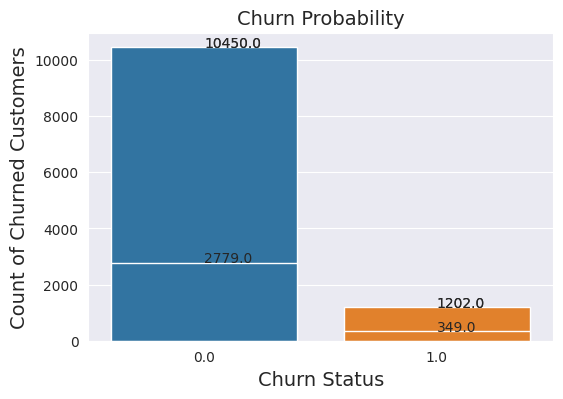

In [21]:
#Analysis on Churn Probability
plt.figure(figsize= (6,4))
PlotAttribute(data, 'churn_probability', 'Churn Probability', 'Churn Status', 'Count of Churned Customers')
PlotAttribute(data_key_customers, 'churn_probability', 'Churn Probability', 'Churn Status', 'Count of Churned Customers')
plt.show()



Note: 

Overall, 10% customers have churned.

Among the total high value customers, 12 % customers have churned.

Approx. Among total customers who have churned, 30% customers are high value customers

### Last Recharge Date

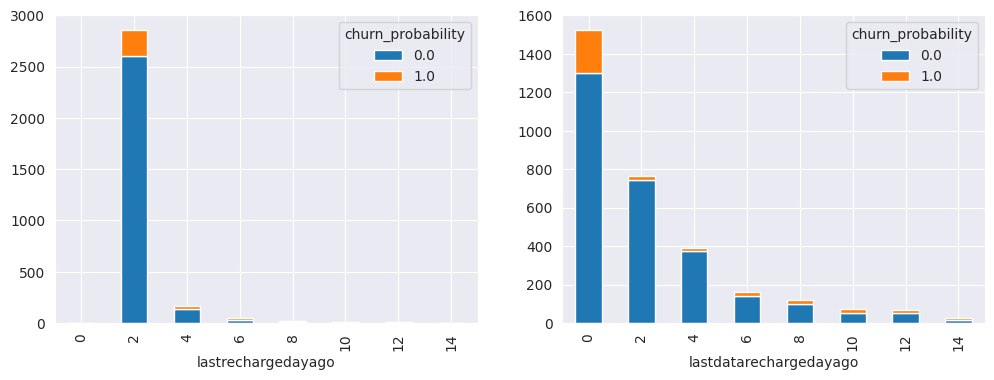

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
# bin the aon column with yearwise segments and plot the counts for each segments
bins = [-1, 0, 2, 4, 6,8, 10, 12, 14]
labels = [0, 2, 4, 6,8, 10, 12, 14]
pd.crosstab(pd.cut(round((data_key_customers['lastrechargedayago']/7),1), bins = bins, labels = labels ), data_key_customers['churn_probability']).plot(kind='bar', stacked=True,  ax = ax1)
pd.crosstab(pd.cut(round((data_key_customers['lastdatarechargedayago']/7),1), bins = bins, labels = labels ), data_key_customers['churn_probability']).plot(kind='bar', stacked=True,  ax = ax2)
plt.show()

Note : 

Even customers who have recharged in the last 2 weeks have churned.

Last Data Recharge being 0 indicates the date is not available. We can see customers who havent recharged data in the recent past/unknown have churned more

### Age on Network

<Figure size 600x400 with 0 Axes>

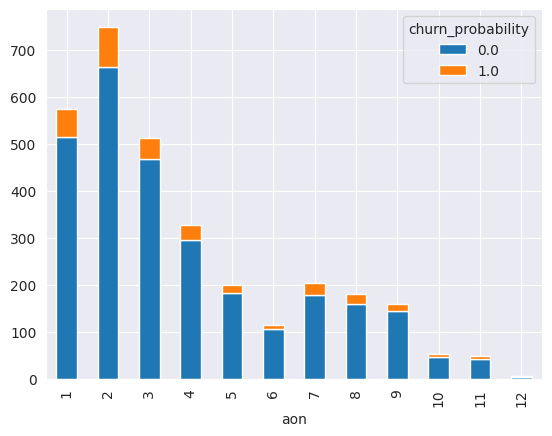

In [23]:
plt.figure(figsize= (6,4))
# bin the aon column with yearwise segments and plot the counts for each segments
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#sns.countplot(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), ax =ax1)
pd.crosstab(pd.cut(round(((data_key_customers['aon']/30)/12),1), bins = bins, labels = labels ), data['churn_probability']).plot(kind='bar', stacked=True)
plt.show()
#Churn probability is higher when aon is between 1 and 3 years.

### Average revenue per user

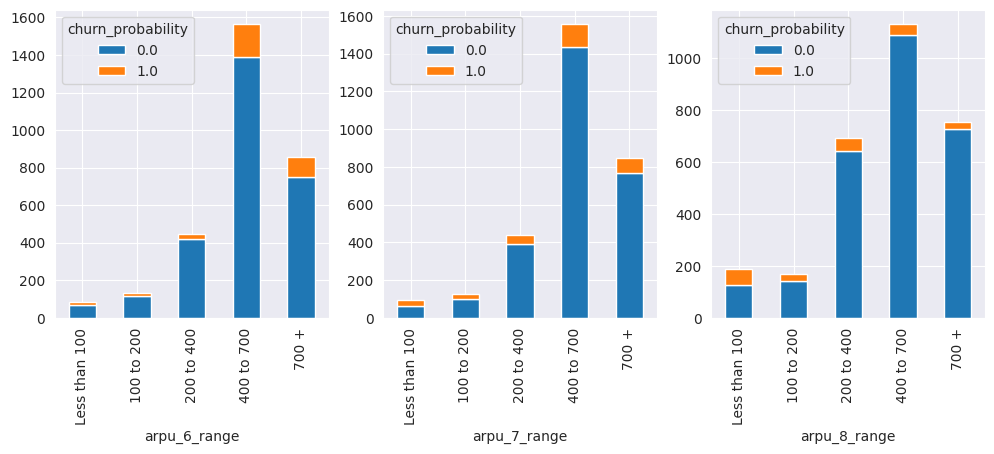

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4))
arpu_bins = [0, 100,200,400,700,15000]
arpu_bucket = ['Less than 100', '100 to 200', '200 to 400', '400 to 700', '700 +']
data_key_customers['arpu_6_range'] = pd.cut(data_key_customers['arpu_6'].astype(int), arpu_bins, labels=arpu_bucket)
data_key_customers['arpu_7_range'] = pd.cut(data_key_customers['arpu_7'].astype(int), arpu_bins, labels=arpu_bucket)
data_key_customers['arpu_8_range'] = pd.cut(data_key_customers['arpu_8'].astype(int), arpu_bins, labels=arpu_bucket)
#print(data['arpu_6_range'].value_counts(), "\n" ,
#data['arpu_7_range'].value_counts() , "\n",
#data['arpu_8_range'].value_counts())
pd.crosstab( data_key_customers['arpu_6_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax1)

pd.crosstab( data_key_customers['arpu_7_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax2)

pd.crosstab( data_key_customers['arpu_8_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax3)


data_key_customers.drop(['arpu_6_range', 'arpu_7_range', 'arpu_8_range'], axis = 1, inplace = True)

# It can be noticed that arpu reduces over the period when the customer is about to churn

In [25]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'total_ic_mou_6':np.sum,'total_ic_mou_7':np.sum,'total_ic_mou_8':np.sum,
                                                                   'total_og_mou_6':np.sum,'total_og_mou_7':np.sum,'total_og_mou_8':np.sum}))).round(2)
table

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn_probability,,,,,,
0.0,"848,363.51","874,890.55","855,762.17","1,973,720.23","2,083,906.62","1,961,703.34"
1.0,"66,435.37","50,318.51","19,634.09","290,048.26","223,663.11","81,266.58"


Note: In the action phase, there is decline in both incoming and outgoing minutes

In [26]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={ 'total_rech_amt_6':np.sum,'total_rech_amt_7':np.sum,'total_rech_amt_8':np.sum,
                                                                   'last_day_rch_amt_6':np.sum,'last_day_rch_amt_7':np.sum,'last_day_rch_amt_8':np.sum}))).round(2)
table

,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
churn_probability,,,,,,
0.0,"289,332.0","287,973.0","273,971.0","1,923,072.0","1,979,598.0","1,835,639.0"
1.0,"34,926.0","21,487.0","9,803.0","263,279.0","182,019.0","76,759.0"


Note: We can see recharge amount going down from July itself in case of churn customers. 

In [27]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'arpu_6':np.sum,'arpu_7':np.sum,'arpu_8':np.sum,
                                                                   'arpu_3g_6':np.sum,'arpu_3g_7':np.sum,'arpu_3g_8':np.sum,
                                                                   'arpu_2g_6':np.sum,'arpu_2g_7':np.sum,'arpu_2g_8':np.sum}))).round(2)
table

,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_6,arpu_7,arpu_8
churn_probability,,,,,,,,,
0.0,"140,784.84","152,035.03","146,127.9","149,818.12","163,764.26","157,773.87","1,653,148.82","1,689,701.13","1,582,320.04"
1.0,"13,302.25","10,329.9","4,862.37","14,266.09","10,384.68","4,988.97","228,173.74","160,128.02","72,134.2"


Note : In cases of churn, we can notice arpu declining over the period. Arpu is a good indicator to identify customer who might churn soon.

### Categorical Fields - Service packs 

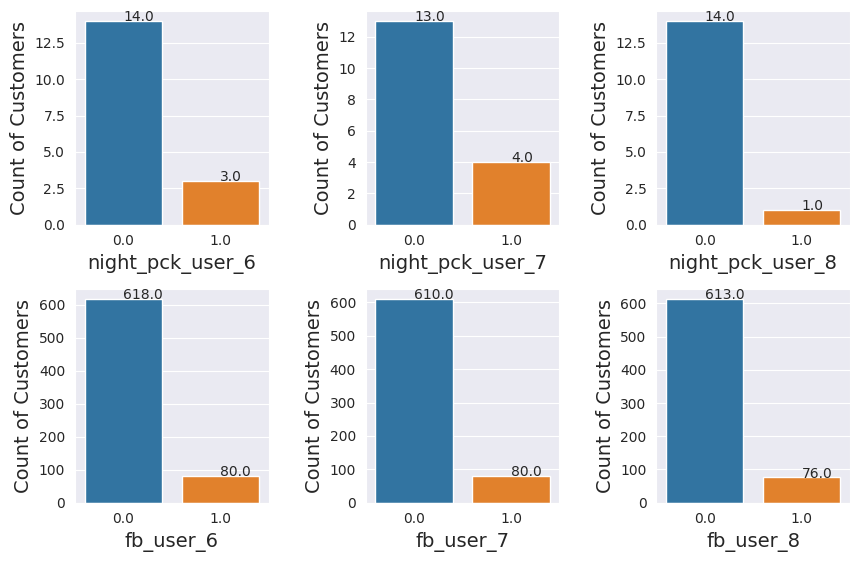

In [28]:
#Analysis on categorrical fields
category_list = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']
counter = 1

plt.figure(figsize = (10, 10))

for col_list in category_list:
    plt.subplot(3, 3, counter)
    service_data = data_key_customers.loc[(data[col_list] == 1)]
    PlotAttribute(service_data, 'churn_probability', '', col_list, 'Count of Customers')
    counter += 1

plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.5)
plt.show()

Note : There doesnt seem to be much variation in night pack /3g sachet but there is slight reduction in Facebook service usage among churn customers

In [29]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'total_og_mou_6':np.sum,'total_og_mou_7':np.sum,'total_og_mou_8':np.sum,
                                                                   'total_ic_mou_6':np.sum,'total_ic_mou_7':np.sum,'total_ic_mou_8':np.sum,
                                                                   'av_rech_amt_data_6':np.sum,'av_rech_amt_data_7':np.sum,'av_rech_amt_data_8':np.sum}))).round(2)
table

,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn_probability,,,,,,,,,
0.0,"255,896.0","284,777.16","266,589.76","848,363.51","874,890.55","855,762.17","1,973,720.23","2,083,906.62","1,961,703.34"
1.0,"21,709.0","16,096.0","7,332.5","66,435.37","50,318.51","19,634.09","290,048.26","223,663.11","81,266.58"


Note : Outgoing calls, Incoming Calls and recharge amount for data seems to be declining for during the action phase in cases of customer churning

<Figure size 600x400 with 0 Axes>

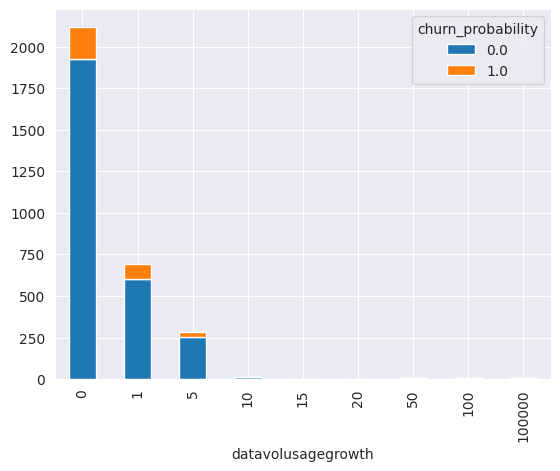

In [30]:
plt.figure(figsize= (6,4))
# bin the aon column with yearwise segments and plot the counts for each segments
bins = [-10, -1, 0, 1, 5, 10, 15, 20, 50, 100, 100000]
labels = [ -1, 0, 1, 5, 10, 15, 20, 50, 100, 100000]
pd.crosstab(pd.cut(round(data_key_customers['datavolusagegrowth'],1), bins = bins, labels = labels ), data['churn_probability']).plot(kind='bar', stacked=True)
plt.show()
#Churn probability is higher when aon is between 1 and 3 years.

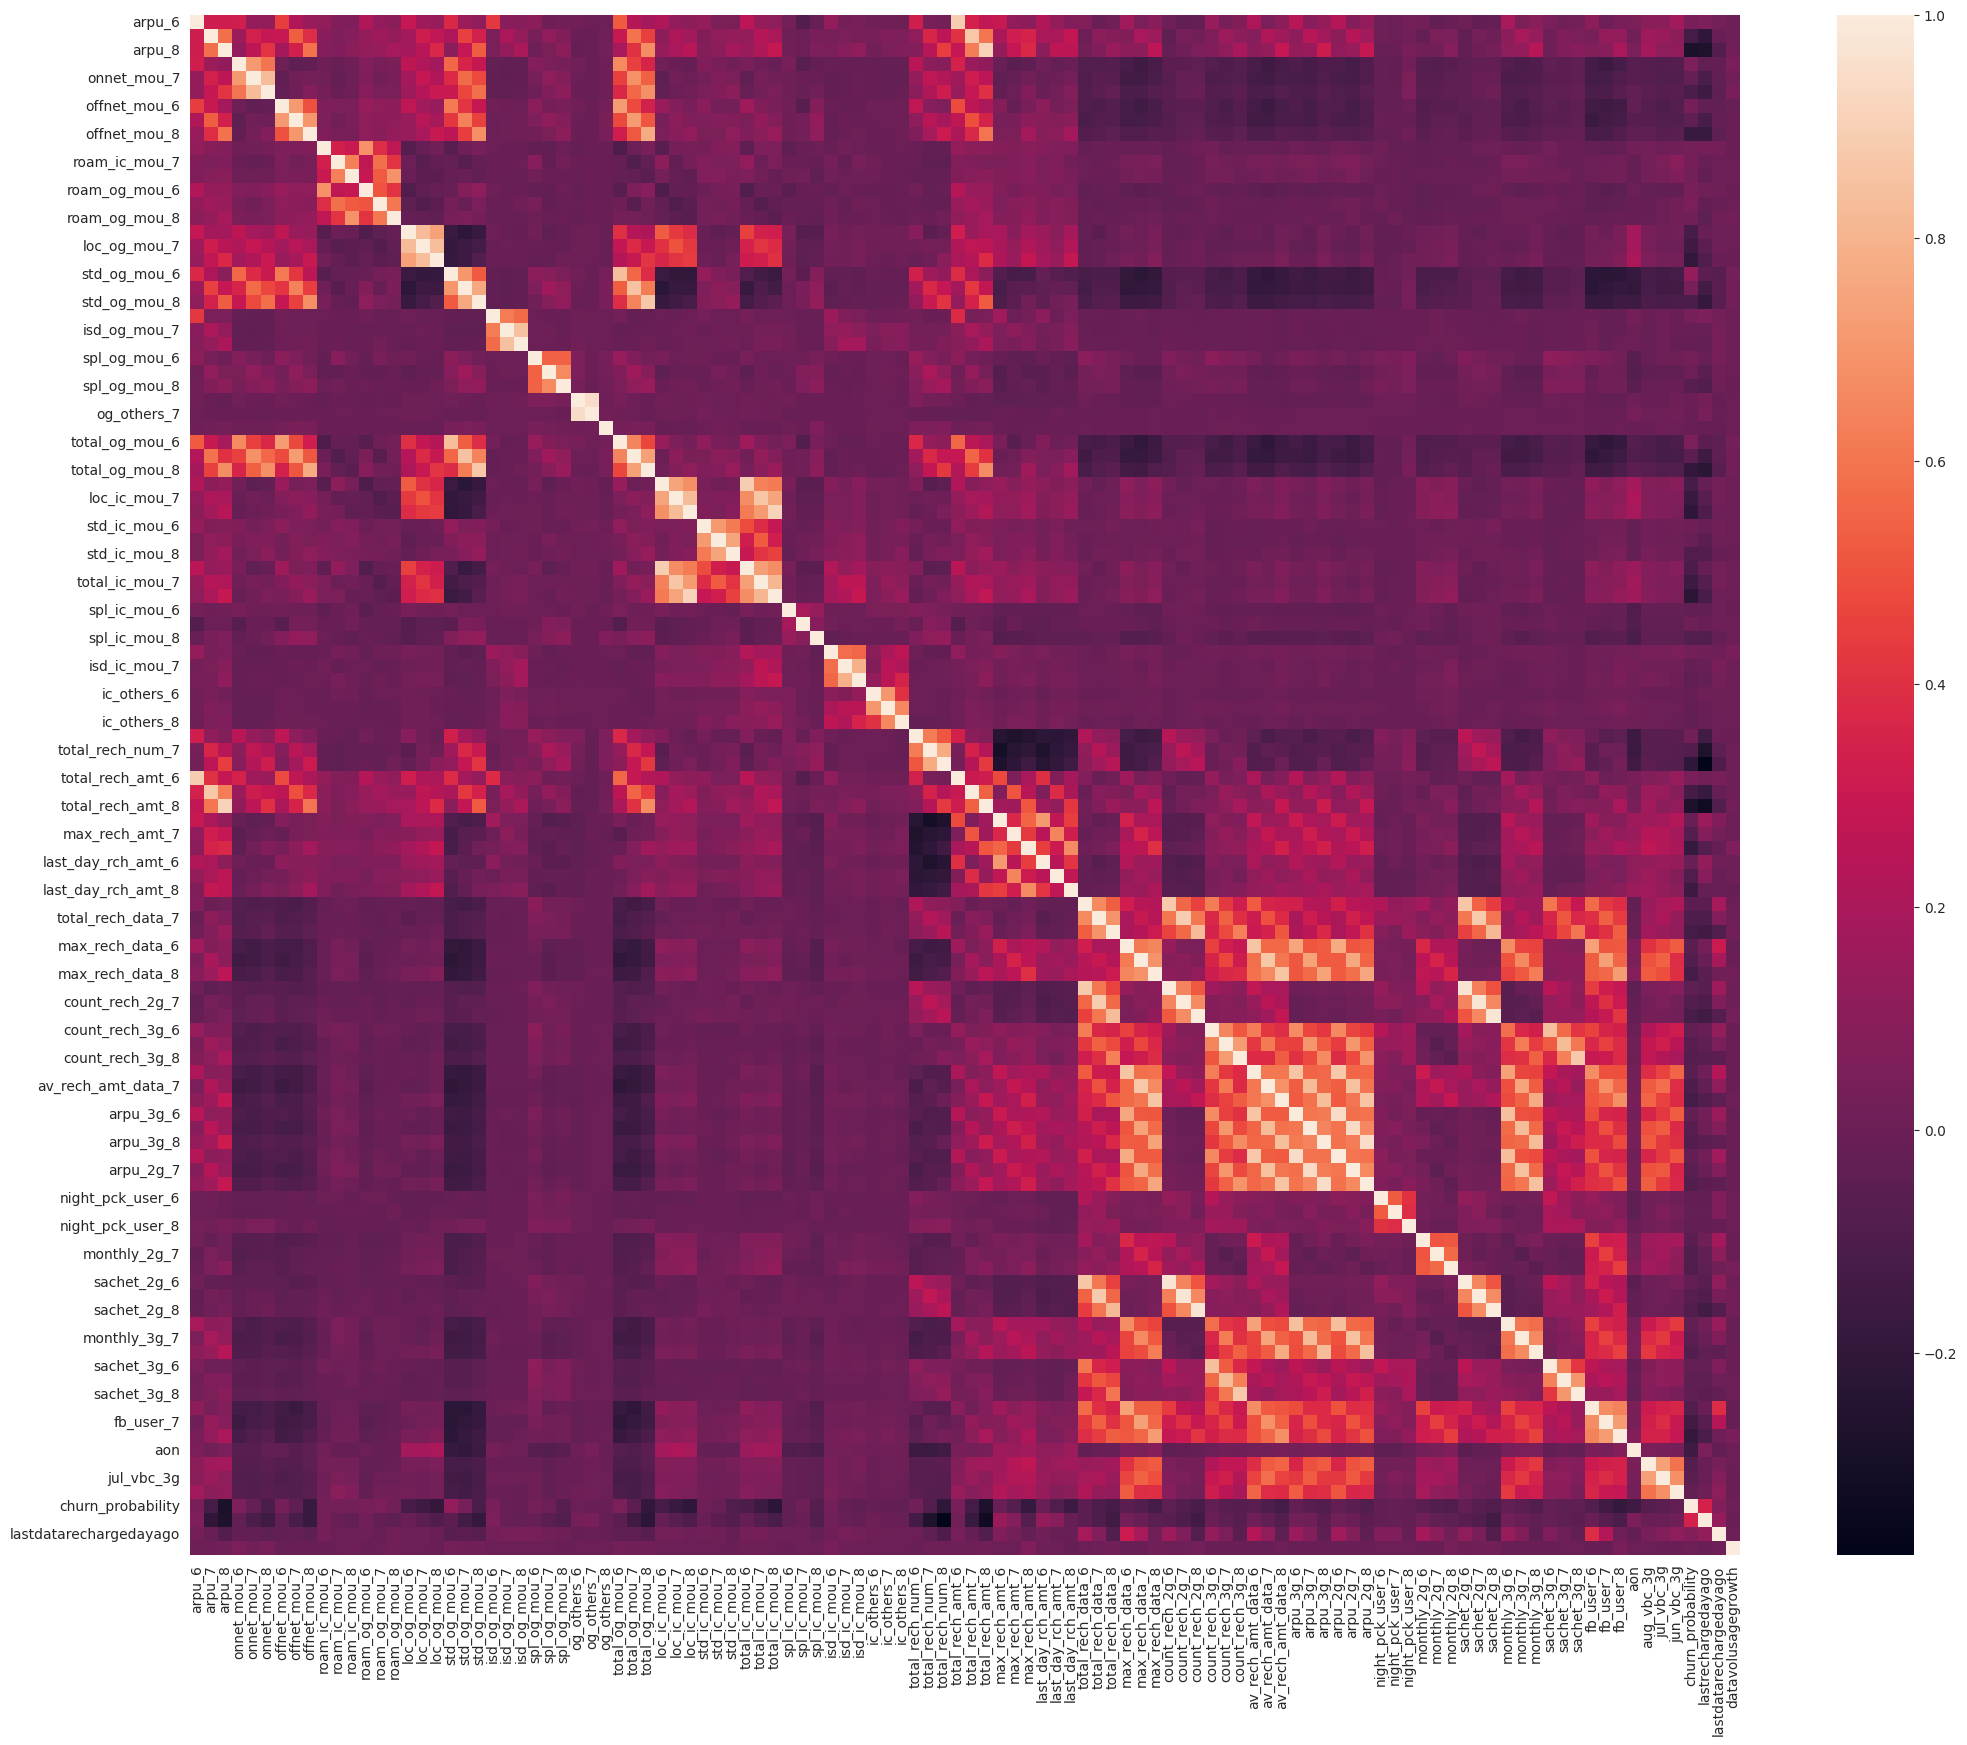

In [31]:
plt.figure(figsize = (25, 20))

sns.heatmap(data_key_customers.corr())

plt.show()

In [32]:
corr_matrix = data_key_customers.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
upper_triangle = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)))

highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]
print("List of highly correlated features from the above plot - \n\n", highly_correlated_features)
print("\n\nTotal features with high correlation - ", len(highly_correlated_features))

List of highly correlated features from the above plot - 

 ['onnet_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 'isd_og_mou_8', 'og_others_7', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


Total features with high correlation -  36


Note: On inspecting the data, we can see that are relationships betweens many columns. Few are  -


loc_og_mou_* = loc_og_t2t_mou_*
	     + loc_og_t2m_mou_*
	     + loc_og_t2f_mou_*
	     + loc_og_t2c_mou_*

std_og_mou_* = std_og_t2t_mou_*
	     + std_og_t2m_mou_*
	     + std_og_t2f_mou_*
	     + std_og_t2c_mou_*

total_og_mou_* = loc_og_mou_*
	      + std_og_mou_*
	      + isd_og_mou_*
	      + spl_og_mou_*
	      + X

loc_ic_mou_* = loc_ic_t2t_mou_*
	     + loc_ic_t2m_mou_*
	     + loc_ic_t2f_mou_*

std_ic_mou_* = std_ic_t2t_mou_*
	     + std_ic_t2m_mou_*
	     + std_ic_t2f_mou_*
	     + std_ic_t2o_mou_*

total_ic_mou_* = loc_ic_mou_*
	     + std_ic_mou_*
	     + spl_ic_mou_*
	     + isd_ic_mou_*
	     + Y

arpu_3g_* ,  arpu_2g_* and arpu are correlated. 
total_rech_amt_*, max_rech_amt_*, last_day_rch_amt_* and av_rech_amt_data_* are correlated.


The highly correlated attributes can be dropped but we will be using PCA to reduce dimension and it will be handled as part of it.

We can derive a consolidated attribute and remove the multiple correlated columns









# 4. Create X, y and then Train test split


In [33]:
data_modelling = data_key_customers.copy()
y = data_modelling.pop('churn_probability')
X = data_modelling

X.shape , y.shape

((3128, 109), (3128,))

Splitting train and test data to avoid any contamination of the test data

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state = 42, stratify = y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2189, 109), (939, 109), (2189,), (939,))

In [35]:
X_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,lastrechargedayago,lastdatarechargedayago,datavolusagegrowth
2368,316.444,544.271,263.178,30.89,17.63,35.28,255.51,256.03,323.96,22.81,162.38,0.0,16.55,155.09,0.0,251.84,103.84,325.24,18.01,14.71,20.16,0.0,0.0,0.0,0.91,0.8,13.83,0.0,0.0,0.0,270.78,119.36,359.24,440.74,109.53,282.28,70.43,21.61,57.14,511.88,132.81,340.29,0.0,0.0,0.0,0.0,0.0,0.05,0.69,1.66,0.81,10.0,7.0,11.0,506.0,543.0,403.0,110.0,110.0,130.0,50.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,530.0,0.0,0.0,0.0,3.0,0.0,0.0
2637,180.04,505.767,86.507,9.13,0.0,0.0,171.44,53.89,24.78,46.26,0.0,0.0,61.26,0.0,0.0,71.33,51.86,24.78,38.01,0.03,0.0,0.0,0.0,0.0,9.96,5.73,0.6,0.0,0.0,0.0,119.31,57.63,25.38,20.08,79.98,58.79,15.38,15.46,11.58,35.46,95.44,70.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,8.0,6.0,0.0,593.0,132.0,0.0,179.0,56.0,0.0,30.0,23.0,0.0,3.0,1.0,0.0,179.0,56.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,503.0,56.0,0.0,423.43,0.0,0.0,430.52,10.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,753.0,378.51,405.92,141.2,2.0,9.0,0.6
3021,266.396,462.003,433.429,89.06,118.46,185.98,178.38,330.69,250.24,0.0,0.0,0.0,0.0,0.0,0.0,65.03,46.43,125.76,201.79,402.73,310.36,0.61,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,267.44,449.16,436.23,86.93,113.43,76.58,114.34,145.34,100.64,300.59,387.38,322.66,0.34,0.16,0.0,98.96,116.91,144.78,0.0,11.51,0.65,26.0,47.0,47.0,300.0,520.0,500.0,30.0,30.0,30.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"2,750.0",0.0,0.0,0.0,3.0,0.0,0.0
149,588.63,317.367,357.411,17.38,6.81,23.98,271.48,149.66,182.78,28.61,0.0,0.0,28.49,0.0,0.0,87.84,91.79,68.38,172.18,64.68,138.38,0.0,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,260.36,156.48,206.76,221.44,151.94,154.43,293.16,255.43,238.33,537.89,452.94,396.48,0.0,0.0,0.0,22.86,7.01,0.0,0.41,38.54,3.71,12.0,6.0,9.0,705.0,395.0,445.0,154.0,198.0,198.0,30.0,50.0,0.0,2.0,1.0,5.0,154.0,198.0,198.0,2.0,1.0,5.0,0.0,0.0,0.0,308.0,198.0,290.0,0.01,0.0,-4.07,4.91,8.17,5.01,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,"1,640.0",769.51,790.9,"1,735.16",2.0,2.0,0.6
1777,732.045,731.566,779.472,"1,045.39","1,113.53","1,023.53",164.48,189.06,99.76,0.0,0.0,0.0,0.0,0.0,0.0,72.76,51.96,34.18,"1,137.11","1,250.63","1,082.94",0.0,0.0,0.0,0.0,17.03,11.79,0.0,0.0,0.0,"1,209.88","1,319.63","1,128.93",63.88,112.49,83.11,38.89,19.86,34.19,102.78,143.09,

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# 5. Model Building

### **Logistics Regression**

#### 1. Logistic Regression with PCA

In [37]:
# Create a logistic regression model
lr = LogisticRegression()

# Define the hyperparameters for tuning
parameters = {'C': [100, 10, 1.0, 0.1, 0.01],
 #             'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'penalty': ['l2']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform hyperparameter tuning using grid search
grid_search = GridSearchCV(estimator=lr, param_grid=parameters, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search.fit(X_train_pca, y_train)

# Get the best model
lr_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = lr_model.predict(X_test_pca)

# Calculate accuracy, recall, and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("\nAccuracy:", accuracy)
print("Recall:", recall)
print("\nConfusion Matrix:")
print(confusion_mat)


Accuracy: 0.9105431309904153
Recall: 0.4

Confusion Matrix:
[[813  21]
 [ 63  42]]



params = {
    'logistic__penalty': ['l1', 'l2'],
    'logistic__C': [0.001, 0.01],
    'logistic__random_state': [42],
    'logistic__class_weight':[{0:2.3, 1: 18.0}],
    'pca__n_components': [p90,p95]
}

###**Random Forest**

Version 1

In [ ]:
## GC: ADDED  HERE
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score

# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
rfc = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
rfc_model = GridSearchCV(estimator=rfc, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

# fit model
rfc_model.fit(X_train_pca, y_train)

# print best hyperparameters
print("Best AUC: ", rfc_model.best_score_)
print("Best hyperparameters: ", rfc_model.best_params_)

# predict churn on test data
y_pred = rfc_model.predict(X_test_pca)

# create accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rfc_model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best AUC:  0.9467039631615087
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 0.4}
Accuracy: 0.931358637814828
[[4896  117]
 [ 270  355]]
Sensitivity: 	0.57
Specificity: 	0.98
AUC:    	 0.94


Version 2

In [47]:
# Random Forest Classifier
rfc2 = RandomForestClassifier()

# Define the hyperparameter grid for tuning
params = {
      "max_features": [10,50,100],
      "n_estimators": [2,5,10],
      "max_depth": [2,3,5,10,20],
      "class_weight":[{0:2.3, 1: 18.0}],
      "min_samples_split": [5,10,20,50,100,500]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search =  GridSearchCV(estimator = rfc2,
                    param_grid = params,
                    cv =5,
                    verbose= 1,
                    scoring ="accuracy")

grid_search.fit(X_train_pca, y_train)

# Get the best estimator from the grid search
rfc2_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = rfc2_model.predict(X_test_pca)

# Calculate accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Get feature importances
feature_importances = rfc2_model.feature_importances_
top_features = X.columns[np.argsort(feature_importances)[::-1]][:5]

# Print the results
print("Top 5 Features:", top_features)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion Matrix:")
print(confusion_mat)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Top 5 Features: Index(['arpu_7', 'onnet_mou_8', 'onnet_mou_6', 'offnet_mou_6', 'arpu_6'], dtype='object')
Accuracy: 0.9009584664536742
Recall: 0.41904761904761906
Confusion Matrix:
[[802  32]
 [ 61  44]]


In [ ]:
# class imbalance
# Idnentiying Weights
w0 = y_train.value_counts().sum()/y_train.value_counts()[0]*2
w1 = y_train.value_counts().sum()/y_train.value_counts()[1]*2
w0,w1

(2.2495083368961093, 18.031528444139823)

### 3. XGBoost

Version 1

In [48]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300]
}

# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy, recall, and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion Matrix:")
print(confusion_mat)


Accuracy: 0.9307774227902024
Recall: 0.6
Confusion Matrix:
[[811  23]
 [ 42  63]]


# 6. Identify Key Features 

### 1. Simple Random Forest Model

In [49]:
#GC: ADDED HERE
# Create an instance of the Random Forest Classifier
#rf_model = RandomForestClassifier(random_state=42)
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
rf_model = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a dataframe of feature importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
top_features = feature_importance_df.nlargest(5, 'Importance')

print('Top 5 Features:')
print(top_features)

print('Accuracy:', accuracy)
print('Confusion Matrix:')
print(confusion_mat)


Top 5 Features:
               Feature           Importance
41      total_ic_mou_8  0.07150965756792532
35        loc_ic_mou_8  0.06518325209105555
56    total_rech_amt_8  0.06368879034516081
17        loc_og_mou_8 0.058293258998826175
62  last_day_rch_amt_8 0.044729389341690635
Accuracy: 0.9275825346112886
Confusion Matrix:
[[815  19]
 [ 49  56]]


# 7. Business Recommendations

Note: Key factors which can help identify churn are - 

1. loc_ic_mou_8  
2. arpu_8 
3. total_ic_mou_8
4. total_og_mou_8
5. total_rech_amt_8

Incoming calls, Outgoing calls, Recharge amount and Average Revenue per unit during the action phase can be used to predict churn. 

Recommendations:

1. As per study, network quality is a key criteria customer looks for and the company can improve their effort towards improving their network quality

https://www.ijert.org/research/a-survey-on-factors-impacting-churn-in-telecommunication-using-datamininig-techniques-IJERTV3IS031583.pdf 

2. People who are relatiely new to the company ( aon -1-3) churn more than others so the telecom company can look to introduce some offers around data or IC/OG calls

3. Company could look to provide some package offers - calls/data/facebook service. We could see if we can information on the customer profile - age/occupation and offer packages accordingly i.e Facebook pack for college student.